In [121]:
# Data Handling
import numpy as np
import pandas as pd
import h5py
from torch.utils.data import DataLoader, TensorDataset

# Machine Learning & Deep Learning
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# Neuroimaging
import nibabel as nib  # For loading NIfTI files
from nilearn.connectome import ConnectivityMeasure  # For connectivity matrices

# Data Preprocessing & Visualization
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split


# LOADING THE DATA

In [122]:
file_path = "Data_ML/SC_FC_dataset_filtered_68x68.h5"

In [123]:
# Load data for CTRL and SCHZ
with h5py.File(file_path, "r") as f:
    ctrl_data = f["SC_ADC"]["ctrl"][:]  # Load control group data
    schz_data = f["SC_ADC"]["schz"][:]  # Load schizophrenia group data

ctrl_data = (ctrl_data - np.min(ctrl_data)) / (np.max(ctrl_data) - np.min(ctrl_data))  # Normalize to [0,1]
ctrl_data = 2 * ctrl_data - 1  # Normalize to [-1,1]
ctrl_tensor = torch.tensor(ctrl_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

schz_data = (schz_data - np.min(schz_data)) / (np.max(schz_data) - np.min(schz_data))  
schz_data = 2 * schz_data - 1 
schz_tensor = torch.tensor(schz_data, dtype=torch.float32).unsqueeze(1) 

# Use only CTRL data for training GAN
train_data = ctrl_tensor
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Method 1: Using GANs (Generative Adversarial Networks)

# A. Conventional GAN

*A priori*, this should not be the optimal method as conventional GANs are usually not the best approaches for complex datasets, such as connectomes.

**i. Generator** creates fake data

In [124]:
class Generator_GAN(nn.Module):
    def __init__(self, latent_dim):
        super(Generator_GAN, self).__init__()
        self.model =  nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 68 * 68),
            nn.Tanh()  # Output in range [-1; 1]
        )
    def forward(self, z):
        return self.model(z).view(-1, 1, 68, 68)

**ii. Discriminator** tries to distinguish real from fake

In [125]:
class Discriminator_GAN(nn.Module):
    def __init__(self):
        super(Discriminator_GAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(68 * 68, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),  # Represents the network’s confidence about input image being real or generated
            nn.Sigmoid()  # Output probability of being real
        )

    def forward(self, x):
        return self.model(x.view(-1, 68 * 68))

**Why we use Leaky ReLUs in the Discriminator and normal ones in the Generator** : 

ReLUs can suffer from the *dying ReLU* problem where some neurons get stuck and stop learning because they always output zero. However, in the context of the Generator, ReLU allows efficient learning for the Generator. Additionally, batch normalization normalizes the activations within each batch, which helps control the scale of the activations and reduces the risk of vanishing or exploding gradients. Lastly, the Generator usually has a higher learning rate than the Discriminator, which also accounts for the fact that it is not as problematic as it could be with the latter.

A LeakyReLU mitigates the *dying ReLU* issue by allowing a small, non-zero gradient for negative inputs. This ensures that even if a neuron’s output is negative, it still has some gradient flow during backpropagation and does not get "stuck" during training. In the Discriminator, we want to make sure that the model's weights are updated appropriately, even if the output of a neuron is negative. LeakyReLU allows this, because instead of zeroing out negative activations like normal ReLU does, it allows a small negative slope. This helps keep the gradient flow alive, preventing parts of the Discriminator from becoming inactive or "dead."

**iii. Training loop**

In [126]:
# Hyperparameters
latent_dim = 100  # Dimensionality of the input noise vector
lr_G = 0.0004
lr_D = 0.0002
epochs = 5000

# Initialize models
generator = Generator_GAN(latent_dim)
discriminator = Discriminator_GAN()

# Loss & Optimizers
criterion = nn.BCELoss()  # Task is binary classification — distinguishing real from fake data
optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5, 0.999))

# Training Loop
for epoch in range(epochs):
    for real_data in train_loader:
        real_data = real_data.view(-1, 68 * 68)  # Flatten (cf. Discriminator input)
        batch_size = real_data.size(0)

        # Generate fake data
        z = torch.randn(batch_size, latent_dim)  #  Sample random noise (latent vector, of dim = latent_dim)
        fake_data = generator(z)

        # Train Discriminator : learns to distinguish real from fake samples
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))  # Real -> 1
        fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))  # Fake -> 0
        loss_D = real_loss + fake_loss
        loss_D.backward()
        optimizer_D.step()

        # Train Generator : tries to fool the Discriminator by generating realistic data 
        
        optimizer_G.zero_grad()
        loss_G = criterion(discriminator(fake_data), torch.ones(batch_size, 1))  # Fool Discriminator
        loss_G.backward()
        optimizer_G.step()    

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss_D={loss_D.item()}, Loss_G={loss_G.item()}")

Epoch 0: Loss_D=1.3239789009094238, Loss_G=0.6940433979034424
Epoch 500: Loss_D=1.5226798057556152, Loss_G=0.6303067803382874
Epoch 1000: Loss_D=1.5351269245147705, Loss_G=0.6104888916015625
Epoch 1500: Loss_D=1.2119834423065186, Loss_G=0.8381507992744446
Epoch 2000: Loss_D=1.3180224895477295, Loss_G=0.6941385865211487
Epoch 2500: Loss_D=1.4032493829727173, Loss_G=0.7625053524971008
Epoch 3000: Loss_D=1.4526314735412598, Loss_G=0.659332811832428
Epoch 3500: Loss_D=1.4264601469039917, Loss_G=0.6788215041160583
Epoch 4000: Loss_D=1.4311171770095825, Loss_G=0.7471550703048706
Epoch 4500: Loss_D=1.4228932857513428, Loss_G=0.66986083984375


**Why do we choose a low learning rate ?** Because GANs are notorious for being unstable to train, as the Generator and Discriminator are trying to outsmart each other in a zero-sum game. Therefore, a lower learning rate allows for more gradual and controlled updates, preventing one network from overshooting the other during training, which helps to balance the learning process between the Generator and Discriminator.

**iv. Generating and plotting new samples**

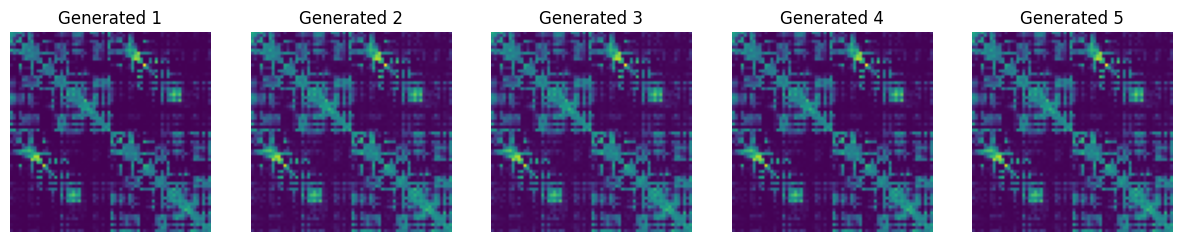

In [127]:
generator.eval()

# Generate new fake samples
with torch.no_grad():
    z_test = torch.randn(5, latent_dim)  
    new_fake = generator(z_test).cpu().numpy()
new_fake = new_fake[:, 0]

fig, axes = plt.subplots(1, 5, figsize=(15, 6))

for i in range(5):
    axes[i].imshow(new_fake[i], cmap="viridis")
    axes[i].set_title(f"Generated {i+1}")
    axes[i].axis("off")

plt.show()

The generated images seem to have the same details (for instance, by comparing the locations of yellow dots), which may indicate mode collapse and / or overfitting, something not surprising when using GANs.

Indeed, GANs are known not to be best suited for high-complexity data. WGANs being supposedly more better suited to such data, let's Generate connectomes with WGANs.

# B. Gradient penalty Wasserstein GAN (GP-WGAN)

Traditional GANs use the Jensen-Shannon (JS) divergence or Kullback-Leibler (KL) divergence as distance metrics between real and generated data distributions, which can lead to mode collapse and training instability.

WGAN introduces the Wasserstein distance (Earth Mover's Distance) as a better measure of distance between probability distributions, that stabilizes training. They are better suited to high-complexity connectomes.

Instead of a Discriminator, a WGAN uses a Critic function, which must satisfy the 1-Lipschitz constraint to ensure the Wasserstein distance is properly computed. Originally, WGAN enforced this using **weight clipping**, but this led to poor optimisation and vanishing gradients. Instead of clipping weights, WGAN-GP **penalizes the gradient** norm of the critic function by adding a term to the loss function : $\lambda \cdot (\|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1)^2$.


The Wasserstein loss used to train the Critic is : $\mathbb{E}[D(G(z))] - \mathbb{E}[D(x)]$

Hence, the total loss is : $\mathbb{E}[D(G(z))] - \mathbb{E}[D(x)] + \lambda \cdot (\|\nabla_{\hat{x}} D(\hat{x})\|_2 - 1)^2$, while the Generator loss is : $-\mathbb{E}[D(G(z))]$

**i. Generator** which maps random noise z to a generated image, as in a conventional GAN -> *we implement WGAN with GAN generator*

**ii. Critic (instead of discriminator)** that outputs a scalar score (instead of class probabilities) indicating how real the input is

In [138]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(68 * 68, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)  # No Sigmoid since the output is a real-valued score.
        )

    def forward(self, x):
        return self.model(x.view(-1, 68 * 68))


**iii. Gradient penalty**

Computing **gradient penalty** to avoid weight clipping (which is used for usual WGAN) : weight clipping forces parameters into a small range, such that the Critic becomes less expressive and underfits. This is especially problematic when working with high-dimensional data. In contrast, WGAN-GP enforces the Lipschitz constraint by penalizing gradients that deviate from 1. This removes the problems of weight clipping and allows a more more stable training process, allowing WGAN-GP to generate higher-quality samples and to converge faster. By choosing WGAN-GP, Adam can be used as an optimizer.

In [139]:
def compute_gradient_penalty(critic, real_samples, fake_samples, lambda_gp=10):
    batch_size = min(real_samples.size(0), fake_samples.size(0)) # Ensure samples are the same size

    real_samples = real_samples[:batch_size]
    fake_samples = fake_samples[:batch_size]

    # Sample alpha from uniform distribution
    alpha = torch.rand(batch_size, 1, 1).to(real_samples.device)  # Match batch size
    # Interpolation between real data and fake data
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    critic_interpolates = critic(interpolates)

    gradients = autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True, retain_graph=True
    )[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

**lambda_gp** is a regularization hyperparameter that scales the gradient penalty in the WGAN-GP loss function. It ensures the 1-Lipschitz continuity condition by penalizing large gradients.

**Training WGAN-GP**

In [142]:
n_critic = 8  # Train the Critic 8 times per Generator step
lambda_gp = 10
lr_C = 0.00005
num_epochs = 500

generator = Generator_GAN(latent_dim).cpu()  # We take the same Generator for WGAN as for the conventional GAN
critic = Critic().cpu()

optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=lr_C, betas=(0.5, 0.9))

In [143]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        real_samples = data[0]
        real_samples = real_samples.cpu()

        for _ in range(n_critic):
            optimizer_C.zero_grad()

            # Generate fake samples
            z = torch.randn(batch_size, latent_dim).cpu()
            fake_samples = generator(z)

            
            loss_critic = critic(fake_samples).mean() - critic(real_samples).mean()
            gradient_penalty = compute_gradient_penalty(critic, real_samples, fake_samples, lambda_gp)

            total_loss_C = loss_critic + gradient_penalty
            total_loss_C.backward()
            optimizer_C.step()

        # Train Generator once per loop
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim).cpu()
            fake_samples = generator(z)

            loss_generator = -critic(fake_samples).mean()
            loss_generator.backward()
            optimizer_G.step()

    if epoch % 25 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Critic Loss: {total_loss_C.item():.4f} | Generator Loss: {loss_generator.item():.4f}")

Epoch [1/500] | Critic Loss: 6.2305 | Generator Loss: 0.1602
Epoch [26/500] | Critic Loss: 6.4713 | Generator Loss: -214.4992
Epoch [51/500] | Critic Loss: 10.3213 | Generator Loss: -534.1953
Epoch [76/500] | Critic Loss: 4.7084 | Generator Loss: -733.9320
Epoch [101/500] | Critic Loss: 6.7420 | Generator Loss: -753.0793
Epoch [126/500] | Critic Loss: 7.9660 | Generator Loss: -244.8502
Epoch [151/500] | Critic Loss: 1.6733 | Generator Loss: -556.6199
Epoch [176/500] | Critic Loss: -2.3874 | Generator Loss: -735.7802
Epoch [201/500] | Critic Loss: 2.6349 | Generator Loss: -515.4739
Epoch [226/500] | Critic Loss: 0.2745 | Generator Loss: -444.1913
Epoch [251/500] | Critic Loss: -0.3666 | Generator Loss: -696.2697
Epoch [276/500] | Critic Loss: 3.7069 | Generator Loss: -709.8893
Epoch [301/500] | Critic Loss: 0.8708 | Generator Loss: -658.4685
Epoch [326/500] | Critic Loss: -5.1882 | Generator Loss: -1091.7467
Epoch [351/500] | Critic Loss: 0.7139 | Generator Loss: -986.6212
Epoch [376/50

**What we expect :** the Critic should decrease and converge to 0 as it is able to distinguish real from fake samples. The results seem improved compared to the ones obtained with the previous GAN. However, it is still relatively unstable.

We proceed with diffusion models.

**Generate Augmented Connectomes**

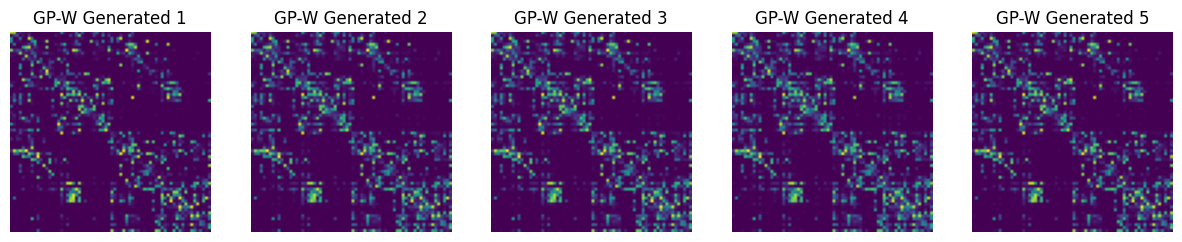

In [132]:
generator.eval()

# Generate new fake samples
with torch.no_grad():
    z_test = torch.randn(5, latent_dim)  
    new_fake = generator(z_test).cpu().numpy()
generated_connectome = new_fake[:, 0]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axes[i].imshow(generated_connectome[i], cmap="viridis")
    axes[i].set_title(f"GP-W Generated {i+1}")
    axes[i].axis("off")

plt.tight_layout
plt.show()

# C. VAE-GAN

**i. Encoder Network (VAE)**

In [133]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512),
        self.fc2 = nn.Linear(512, 256),
        self.fc3_mu = nn.Linear(256, latent_dim)
        self.fc3_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.fc3_mu(x)
        logvar = self.fc3_logvar(x)
        return mu, logvar


**ii. Decoder Network (VAE & GAN Generator)**

In [134]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, output_dim)
    
    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        return torch.tanh(self.fc3(z))  # Output in range [-1, 1]

**iii. Discriminator Network (GAN)**

In [135]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Probability of being real

**VAE-GAN Training Loop**

In [136]:
def train_vae_gan(encoder, decoder, discriminator, dataloader, optimizer_EG, optimizer_D, epochs=100, lambda_gp=0.1):
    for epoch in range(epochs):
        for data in dataloader:
            real_data = data[0].view(-1, 68 * 68)  # Flatten the data
            batch_size = real_data.size(0)
            
            # ===== Train Discriminator =====
            optimizer_D.zero_grad()
            z = torch.randn(batch_size, latent_dim)
            fake_data = decoder(z)

            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            real_loss = nn.BCELoss()(discriminator(real_data), real_labels)
            fake_loss = nn.BCELoss()(discriminator(fake_data.detach()), fake_labels)
            loss_D = real_loss + fake_loss
            loss_D.backward()
            optimizer_D.step()

            # Train Encoder-Decoder
            optimizer_EG.zero_grad()

            # VAE Loss: Reconstruction + KL Divergence
            mu, logvar = encoder(real_data)
            std = torch.exp(0.5 * logvar)
            qz = torch.normal(mu, std)
            recon_data = decoder(qz)

            recon_loss = nn.MSELoss()(recon_data, real_data)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            vae_loss = recon_loss + kl_loss

            # GAN Loss (Fooling the Discriminator)
            gen_loss = nn.BCELoss()(discriminator(recon_data), real_labels)
            total_loss = vae_loss + lambda_gp * gen_loss
            total_loss.backward()
            optimizer_EG.step()

        print(f"Epoch [{epoch}/{epochs}], VAE Loss: {vae_loss.item()}, GAN Loss: {gen_loss.item()}")

latent_dim = 100
input_dim = 68 * 68
output_dim = input_dim  # Same as input size for reconstruction
epochs = 100

encoder = Encoder(input_dim, latent_dim)
decoder = Decoder(latent_dim, output_dim)
discriminator = Discriminator(output_dim)

optimizer_EG = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


train_vae_gan(encoder, decoder, discriminator, train_loader, optimizer_EG, optimizer_D, epochs)


TypeError: 'tuple' object is not callable

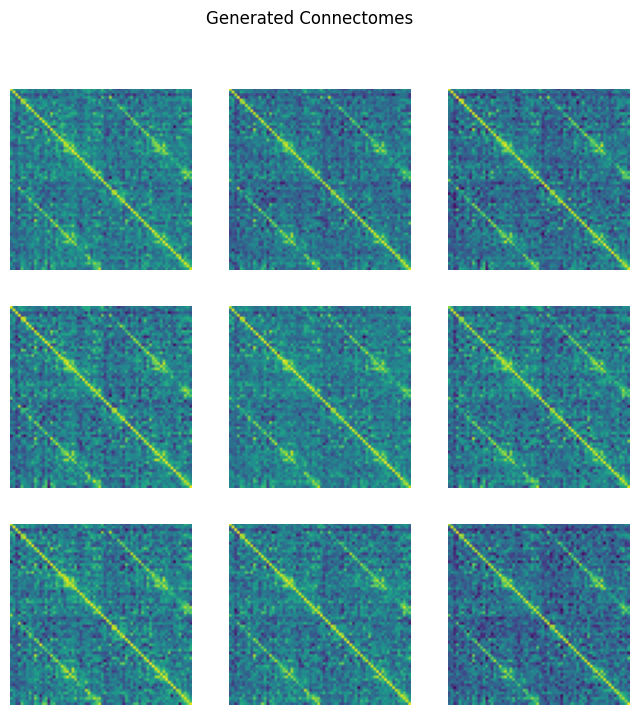

In [ ]:
z = torch.randn(9, latent_dim)  # Sample random latent vectors
generated_images = decoder(z).detach().cpu().numpy()  # Generate images
generated_images = np.reshape(generated_images, (-1, 68, 68))  # Reshape


fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap="viridis") 
    ax.axis("off")
plt.suptitle("Generated Connectomes")
plt.show()

evalution quantitative : générer à la fois ctrl et schz => comparer, comment rendre compte quantitativement de la variabilité

# Method 2 : Using diffusion models

**i. Diffusion Model**

In [144]:
class DiffusionModel:
    def __init__(self, timesteps=100, beta_start=1e-4, beta_end=0.02):
        self.timesteps = timesteps
        self.betas = torch.linspace(beta_start, beta_end, timesteps)
        self.alphas = 1.0 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

    def forward_diffusion(self, x0, t):
        """Adds Gaussian noise to the input correlation matrix."""
        noise = torch.randn_like(x0)
        alpha_t = self.alpha_bar[t].view(-1, 1, 1)
        xt = torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise
        return xt, noise

**ii. Denoising** using GNNs

In [145]:
import torch_geometric
from torch_geometric.nn import GCNConv  # Graph Neural Network layer

class GNN_Denoiser(nn.Module):
    def __init__(self, num_nodes, hidden_dim=64):
        super().__init__()
        self.conv1 = GCNConv(num_nodes, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, num_nodes)

    def forward(self, x, edge_index, t):
        """Denoises the noisy correlation matrix."""
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)
        return (x + x.T) / 2  # Ensure symmetry

**iii. Training function**

In [146]:
def train(model, diffusion, data_loader, optimizer, epochs=10):
    model.train()
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0
        for x0, edge_index in data_loader:
            t = torch.randint(0, diffusion.timesteps, (x0.shape[0],)).long()
            xt, noise = diffusion.forward_diffusion(x0, t)
            predicted_noise = model(xt, edge_index, t)

            loss = loss_fn(predicted_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}: Loss = {total_loss / len(data_loader)}")

**iv. Sampling function**

In [148]:
def sample(model, diffusion, edge_index, num_samples=1, num_nodes=35):
    model.eval()
    with torch.no_grad():
        x_t = torch.randn((num_samples, num_nodes, num_nodes))  # Start with noise
        for t in reversed(range(diffusion.timesteps)):
            predicted_noise = model(x_t, edge_index, torch.tensor([t] * num_samples).long())
            x_t = (x_t - predicted_noise) / torch.sqrt(diffusion.alphas[t])
            x_t = (x_t + x_t.T) / 2  # Ensure symmetry
    return x_t

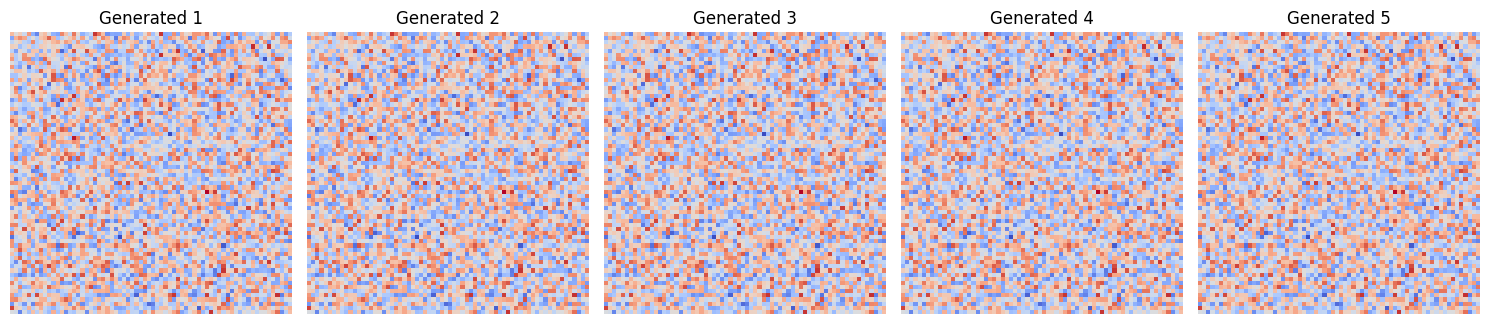

In [ ]:
num_nodes = 35  # Adjust based on dataset
diffusion = DiffusionModel()
model = GNN_Denoiser(num_nodes)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train(model, diffusion, train_loader, optimizer, epochs=50)

# Plot the generated connectomes
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # 5 samples side by side
for i, ax in enumerate(axes):
    ax.imshow(generated_connectomes[i, 0], cmap='coolwarm', interpolation='nearest')
    ax.set_title(f"Generated {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
generated_connectomes = (generated_connectomes - np.mean(generated_connectomes)) / np.std(generated_connectomes)
generated_connectomes = generated_connectomes * np.std(real_data.numpy()) + np.mean(real_data.numpy())  


print("Real connectome range:", real_data.min().item(), real_data.max().item())
print("Generated connectome range:", generated_connectomes.min(), generated_connectomes.max())


Real connectome range: -1.0 1.0
Generated connectome range: -0.6843723 0.8638042
